---
# **Assignment 2 for Clustering: Sessa Empirical Estimator**  
---

$\textbf{R code - Python Code}$

- $\textbf{Using the Med.Events dataset}$

In [103]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score



# Step 1: Load & Preprocess Data
file_path = "med_events.csv"
df = pd.read_csv(file_path)

df.rename(columns={
    "PATIENT_ID": "pnr",    # Patient ID
    "DATE": "eksd",         # Prescription date
    "PERDAY": "perday",     # Daily dosage
    "CATEGORY": "ATC",      # Drug type
    "DURATION": "dur_original"  # Prescription duration
}, inplace=True)

df["eksd"] = pd.to_datetime(df["eksd"], format="%m/%d/%Y")
df = df.sort_values(by=["pnr", "eksd"])

# Step 1.5: Filter Data for a Specific Drug
selected_drug = "medA"  # Change this to "medB" or another drug
df = df[df["ATC"] == selected_drug]

# Step 2: Compute Event Intervals
df["prev_eksd"] = df.groupby("pnr")["eksd"].shift(1)
df["event.interval"] = (df["eksd"] - df["prev_eksd"]).dt.days
df = df.dropna(subset=["event.interval"])

# Step 2.5: Randomly Select One Prescription Per Patient
df_filtered = df.groupby("pnr").apply(lambda x: x.sample(n=min(1, len(x)), random_state=42)).reset_index(drop=True)

df.head()

,pnr,eksd,perday,ATC,dur_original,prev_eksd,event.interval
25,2,2036-03-10,4,medA,50,2036-01-20,50.0
26,2,2036-08-01,4,medA,50,2036-03-10,144.0
61,4,2032-11-27,4,medA,50,2032-05-01,210.0
62,4,2033-08-20,4,medA,50,2032-11-27,266.0
63,4,2033-08-30,4,medA,50,2033-08-20,10.0


$\textbf{ II. Generating the Emperical CDF and filtering the top 20 percent}$ 

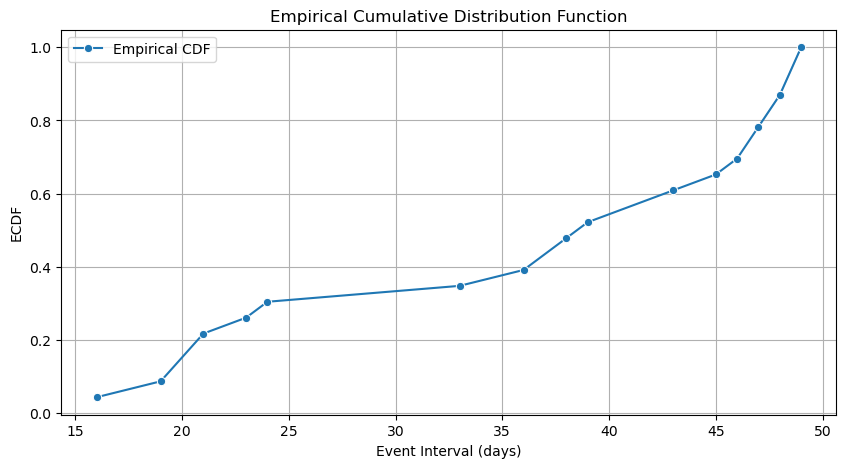

,pnr,eksd,perday,ATC,dur_original,prev_eksd,event.interval,Cluster
5,8,2034-07-17,6,medA,50,2034-06-28,19.0,1
10,14,2031-12-06,2,medA,20,2031-10-29,38.0,4
12,16,2042-01-01,4,medA,50,2041-12-11,21.0,1
17,21,2037-11-26,4,medA,50,2037-10-19,38.0,4
22,27,2037-06-15,4,medA,50,2037-04-30,46.0,2


In [123]:
# Step 3: Generate ECDF & Remove Top 20%
event_intervals = df_filtered["event.interval"].dropna()
ecdf = ECDF(event_intervals)
x = np.sort(event_intervals)
y = ecdf(x)

plt.figure(figsize=(10, 5))
sns.lineplot(x=x, y=y, marker="o", label="Empirical CDF")
plt.xlabel("Event Interval (days)")
plt.ylabel("ECDF")
plt.title("Empirical Cumulative Distribution Function")
plt.grid()
plt.show()

threshold = np.percentile(event_intervals, 80)  # 80th percentile cutoff
df_filtered = df_filtered[df_filtered["event.interval"] <= threshold].copy()
df_filtered["Cluster"] = kmeans_final.predict(scaler.transform(df_filtered[["event.interval"]]))



df_filtered.head()

$\textbf{ III. Applying K-means clustering}$ 

In [112]:
# Step 4: Apply K-Means Clustering
X = df_filtered[["event.interval"]] 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

sil_scores = []
cluster_range = range(2, 10)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, algorithm="elkan", random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    sil_scores.append(score)

optimal_k = cluster_range[np.argmax(sil_scores)]
kmeans_final = KMeans(n_clusters=optimal_k, algorithm="elkan", random_state=42, n_init=10)
df_filtered["Cluster"] = kmeans_final.fit_predict(X_scaled)

df_filtered.head()


,pnr,eksd,perday,ATC,dur_original,prev_eksd,event.interval,Cluster
2,5,2031-12-27,8,medA,30,2031-10-26,62.0,3
3,6,2037-03-24,4,medA,50,2037-01-07,76.0,0
5,8,2034-07-17,6,medA,50,2034-06-28,19.0,1
10,14,2031-12-06,2,medA,20,2031-10-29,38.0,4
11,15,2035-12-25,4,medA,20,2035-10-18,68.0,5


$\textbf{ IV. Assigning Cluster Statistics}$ 

In [121]:
# Step 5: Compute Cluster Statistics
ni2 = df_filtered.groupby("Cluster")["event.interval"].min()
ni3 = df_filtered.groupby("Cluster")["event.interval"].max()
ni4 = df_filtered.groupby("Cluster")["event.interval"].median()

cluster_stats = pd.DataFrame({
    "Cluster": ni2.index,
    "Minimum": ni2.values,
    "Maximum": ni3.values,
    "Median": ni4.values
})
cluster_stats = cluster_stats[cluster_stats["Median"] > 0]

# Step 6: Assign Patients to Clusters
results = df.merge(df_filtered[["pnr", "Cluster"]], on="pnr", how="left")

# Now merge with cluster statistics to get Minimum, Maximum, and Median values
results = results.merge(cluster_stats, on="Cluster", how="left")
results = results[(results["event.interval"] >= results["Minimum"]) & 
                  (results["event.interval"] <= results["Maximum"])]
results.dropna(subset=["Cluster"], inplace=True)

results.head()

,pnr,eksd,perday,ATC,dur_original,prev_eksd,event.interval,Cluster,Minimum,Maximum,Median
6,5,2031-12-27,8,medA,30,2031-10-26,62.0,3.0,56.0,62.0,57.0
18,8,2034-07-17,6,medA,50,2034-06-28,19.0,1.0,16.0,24.0,21.0
19,8,2034-08-03,6,medA,50,2034-07-17,17.0,1.0,16.0,24.0,21.0
23,8,2035-04-13,6,medA,50,2035-03-21,23.0,1.0,16.0,24.0,21.0
49,14,2031-12-06,2,medA,20,2031-10-29,38.0,4.0,33.0,39.0,38.0


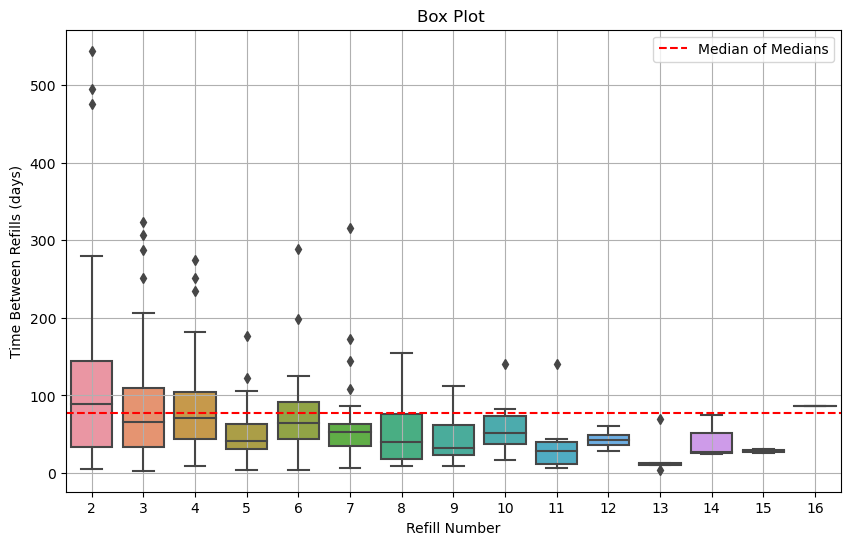

In [ ]:
# Step 7: SEE Assumption Check (Whisker Plot)

# Compute refill sequence number (p_number) per patient
df["p_number"] = df.groupby("pnr").cumcount() + 1

# Filter to remove first refill, as done in R script (only p_number >= 2)
df_filtered = df[df["p_number"] >= 2].copy()

# Compute median of medians per patient
medians_of_medians = df_filtered.groupby("pnr")["event.interval"].median().median()

plt.figure(figsize=(10, 6))
sns.boxplot(x="p_number", y="event.interval", data=df_filtered)

# Add median of medians as reference line
plt.axhline(y=medians_of_medians, linestyle="dashed", color="red", label="Median of Medians")

plt.xlabel("Refill Number")
plt.ylabel("Time Between Refills (days)")
plt.title("Box Plot ")
plt.legend()
plt.grid()
plt.show()
